In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
dataset = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
print("Full train dataset shape is {}".format(dataset.shape))

Full train dataset shape is (1460, 81)


In [5]:
dataset = dataset.drop('Id', axis=1)
dataset.head(3)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_30/3010099981.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


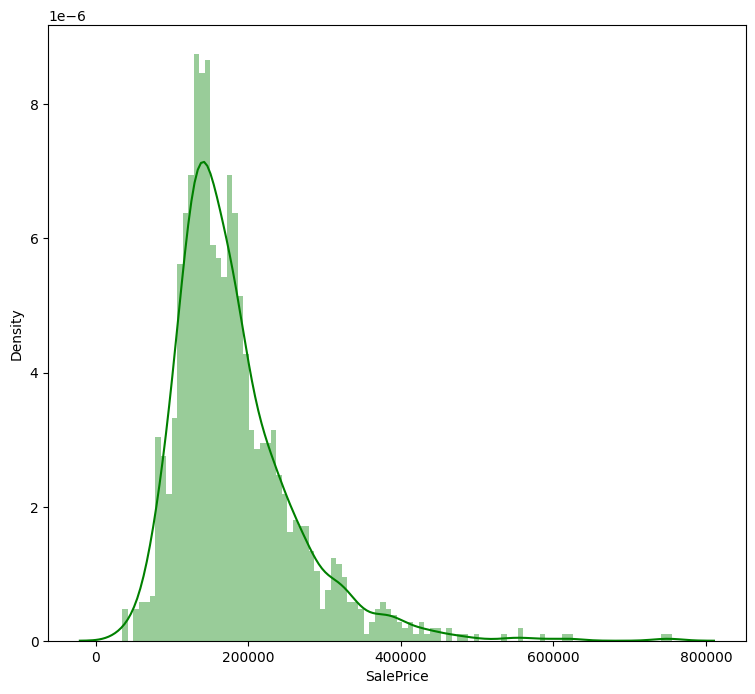

In [17]:
print(dataset['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [7]:
num = dataset.select_dtypes(include = ['float64', 'int64'])
num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


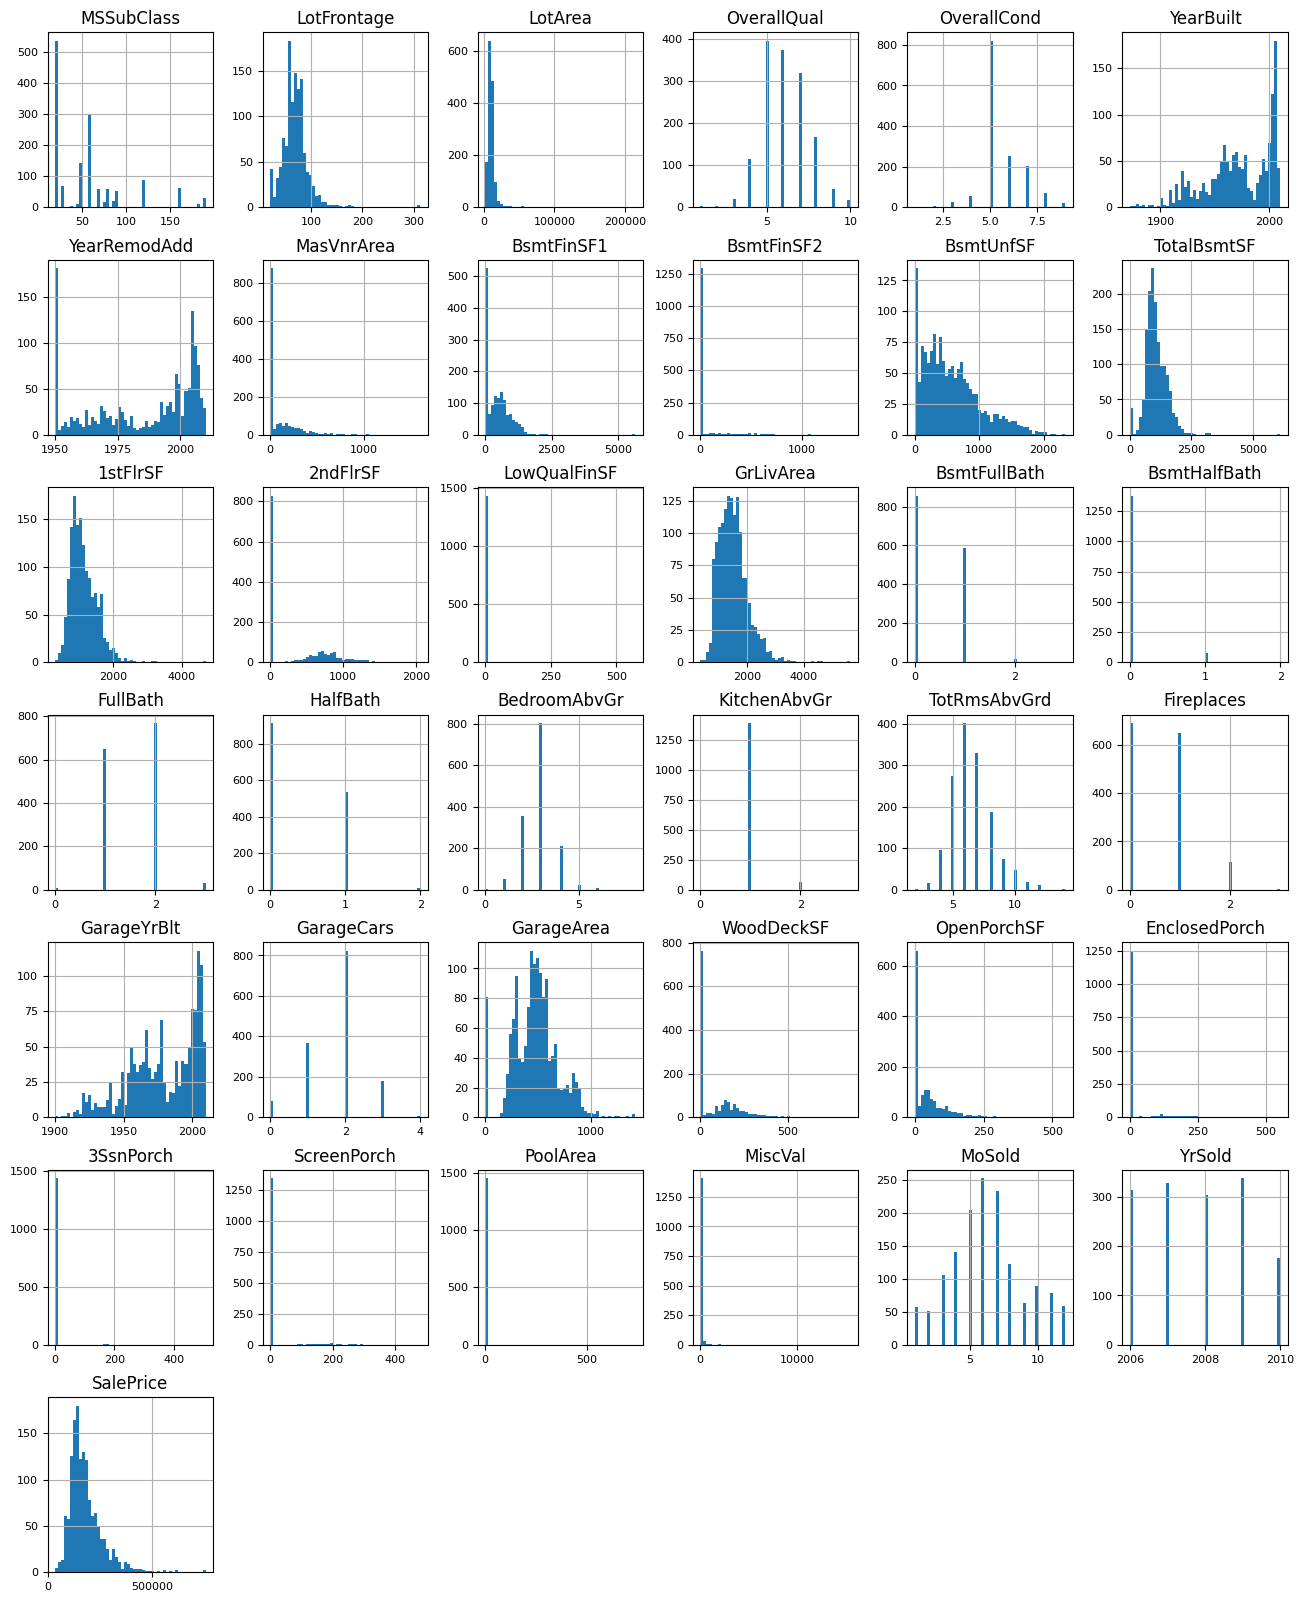

In [8]:
num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


In [9]:
import numpy as np

def split_dataset(datasets, test_ratio=0.30):
  test_indices = np.random.rand(len(datasets)) < test_ratio
  return datasets[~test_indices], datasets[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1036 examples in training, 424 examples in testing.


In [10]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [11]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

Use /tmp/tmp7kjgq8bv as temporary training directory


In [12]:
rf.fit(x=train_ds)
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

Reading training dataset...
Training dataset read in 0:00:06.543401. Found 1036 examples.
Training model...


[INFO 24-10-05 22:04:51.7405 UTC kernel.cc:1233] Loading model from path /tmp/tmp7kjgq8bv/model/ with prefix d031d0db537845b2


Model trained in 0:00:02.042883
Compiling model...


[INFO 24-10-05 22:04:52.0981 UTC decision_forest.cc:734] Model loaded with 300 root(s), 98282 node(s), and 75 input feature(s).
[INFO 24-10-05 22:04:52.0982 UTC abstract_model.cc:1362] Engine "RandomForestOptPred" built
[INFO 24-10-05 22:04:52.0982 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


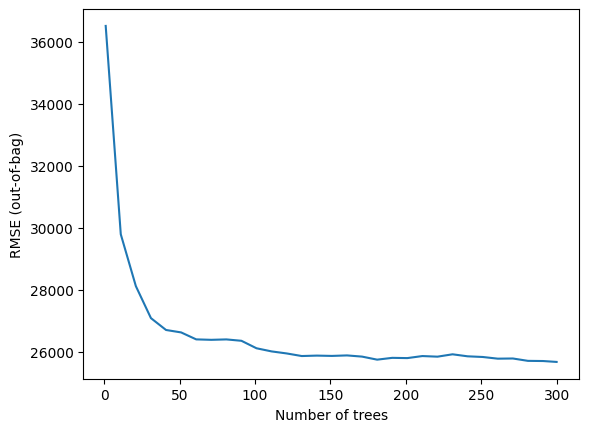

In [13]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

1/1 [==============================] - 4s 4s/step - loss: 0.0000e+00
loss: 0.0000


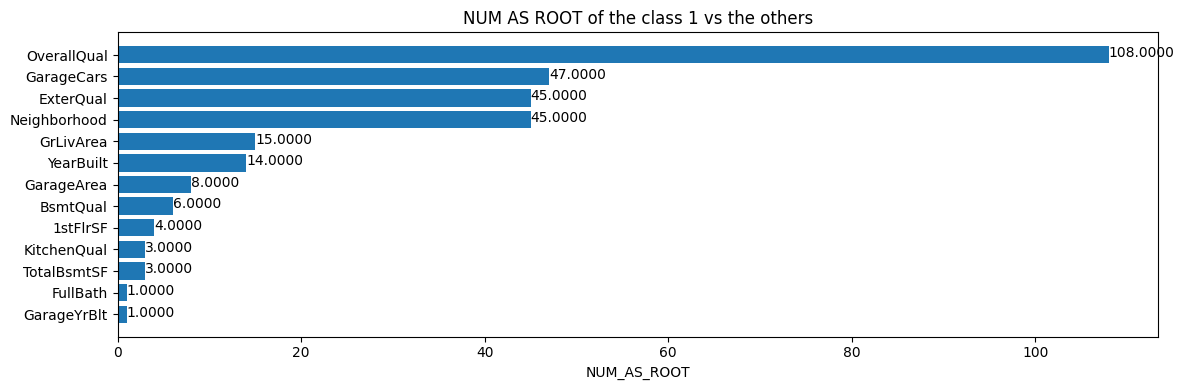

In [15]:
plt.figure(figsize=(12, 4))

inspector = rf.make_inspector()
inspector.evaluation()
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]


feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [ ]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

In [ ]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()